<div style="width: 100%; clear: both;">

<div style="float: left; width: 50%;">

<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">

</div>

<div style="float: right; width: 50%;">

<p style="margin: 0; padding-top: 22px; text-align:right;">M2.991 · Aprenentatge automàtic · PAC2</p>

<p style="margin: 0; text-align:right;">2024-1 · Màster universitari en Ciència de dades (Data science)</p>

<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis d'Informàtica, Multimèdia i Telecomunicació</p>

</div>

</div>

<div style="width:100%;">&nbsp;</div>

# PAC 2: Aprenentatge no supervisat

En aquesta pràctica, explorarem l'ús de models de llenguatge grans (LLMs) per generar embeddings, aplicarem tècniques de reducció de dimensionalitat i utilitzarem diversos algorismes de clustering per analitzar el feedback de clients sobre l'empresa UPS obtingut de Yelp. En acabar, realitzarem una anàlisi detallada dels resultats obtinguts.

**Important:** cadascun dels exercicis pot suposar diversos minuts d'execució, per la qual cosa el lliurament s'ha de fer en format notebook i en format html, on es vegi el codi, els resultats i comentaris de cada exercici. Es pot exportar el notebook a html des del menú File $\to$ Download as $\to$ HTML.

**Important:** hi ha un tipus de cel·la especial per contenir text. Aquest tipus de cel·la us serà molt útil per respondre les diferents preguntes teòriques plantejades al llarg d'aquesta PAC. Per canviar el tipus de cel·la a aquest tipus, trieu al menú: Cell $\to$ Cell Type $\to$ Markdown.

**Important:** no oblideu posar el vostre nom i cognoms a la següent cel·la.

<div class="alert alert-block alert-info">
<strong>Nom i cognoms: Toni Vives Cabaleiro</strong>
</div>

Per a la realització de la pràctica necessitarem importar els següents mòduls:

In [1]:
import json
from typing import List

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import tqdm
import umap
import pandas as pd

seed = 42

C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Càrrega del conjunt de dades i preprocessament (1,5 punts)

S'utilitzarà un dataset de comentaris de clients sobre l'empresa UPS recopilats de [Yelp](https://www.yelp.com/dataset), contingut en l'arxiu reviews_ups.txt, on cada línia és una review. Recordeu que pot haver-hi reviews sense contingut, les quals hauran de ser eliminades durant el preprocessament.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> carrega les opinions de l'arxiu en una llista i elimina aquelles opinions que estiguin literalment buides.
</div>

In [2]:
df = pd.read_json("reviews_stars_ups.json", lines=True)
df.head()

text  stars
0  I went to this location because it's easy to g...      5
1  It's just a place to get my mail. \nIt's about...      3
2  What a scam!  UPS stores charge $2.50 to 'for ...      1
3  Went to this store to get a passport sent to E...      1
4  This is not a review for all UPS Stores, but s...      4

In [3]:
df.isna().sum()

text     0
stars    0
dtype: int64

In [4]:
df.groupby(["stars"]).size()

stars
1    1687
2     228
3     156
4     329
5    2085
dtype: int64

Avui en dia, l'anàlisi de text en llenguatge natural ha estat revolucionat pels Models de Llenguatge Grans (LLMs), els quals han reemplaçat les tècniques clàssiques com TF-IDF i Bag of Words per a la representació de text. Aquestes tècniques clàssiques, tot i que útils, eren limitades en crear representacions disperses i poc contextuals dels textos. En canvi, els LLMs permeten generar representacions denses o embeddings, que capturen de manera molt més efectiva el significat semàntic de les paraules i les relacions entre elles.

Per comprendre com funcionen els models de llenguatge es recomana el següent vídeo que, al minut 12, explica visualment la part d'embeddings (representació vectorial de paraules o frases) que utilitzarem en la PAC: https://www.youtube.com/watch?v=wjZofJX0v4M

En aquesta pràctica, crearem una representació densa (embedding) de les reviews utilitzant MiniLM, un model lleuger que ofereix una excel·lent capacitat per generar embeddings de text mantenint un equilibri entre rendiment i eficiència computacional. MiniLM està basat en l'arquitectura Transformer, similar a altres models més grans com BERT, però optimitzat per ser més petit i ràpid, cosa que el fa ideal per a tasques com la nostra. En concret, utilitzarem la versió "all-MiniLM-L6-v2", que pots descarregar comprimida en un fitxer zip des del següent enllaç: https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/v0.2/all-MiniLM-L6-v2.zip

Un cop descarregat l'arxiu, has de descomprimir-lo i col·locar el directori extret en el mateix directori on es troba aquest notebook, per facilitar-ne la càrrega.

Per carregar el model, utilitzarem la biblioteca sentence-transformers, que és una eina que facilita l'ús de models preentrenats per a la generació d'embeddings de text. Aquesta biblioteca està construïda sobre models com BERT, MiniLM, i altres, i ens permet, amb unes poques línies de codi, transformar frases i textos en representacions vectorials d'alta qualitat. Aquí pots trobar més documentació sobre sentence-transformers i el model en concret de MiniLM: https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

En tenir el model descarregat en local només cal indicar el nom del directori descomprimit on es troba el model (que coincideix amb el nom del model).

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> carrega el model de MiniLM i crea l'embedding per a la frase "Estic resolent la PAC 2"
</div>

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')  
frase = "Estic resolent la PAC 2"
embedding = model.encode(frase)
print("embedding = ", embedding)


embedding =  [-3.28027294e-03  9.02761146e-03  8.79593380e-03  4.49204957e-03
 -1.09555265e-02  3.78498919e-02 -9.98769980e-03  5.73650450e-02
  3.95285301e-02  2.57662646e-02  1.06923534e-02 -1.58949904e-02
 -4.30050828e-02 -2.46332381e-02  1.84600521e-02 -5.43837734e-02
 -3.41768712e-02  8.34198296e-03  1.21009452e-02 -1.74672641e-02
  8.00092891e-02 -6.34780824e-02 -3.30181867e-02  5.67536652e-02
 -8.63865241e-02 -3.15793237e-04  4.39975364e-03  3.19093056e-02
  9.64958221e-03 -9.40813571e-02 -2.25613508e-02  1.46912588e-02
  2.99515855e-02 -3.66251506e-02  2.61850702e-03 -2.37988378e-03
  7.35122338e-02 -1.08080506e-01  8.73353425e-03  6.89906329e-02
 -6.00013919e-02 -6.67898208e-02  4.77782264e-02 -7.64310034e-03
  7.10897334e-03 -1.34137692e-02  3.49888019e-02  1.01962611e-01
 -2.02165581e-02  2.58677881e-02  4.14751237e-03 -2.67684534e-02
 -2.32617538e-02  1.60293456e-03 -1.98684372e-02  7.44951470e-03
  6.73470125e-02  2.02235021e-02  6.36741146e-02 -3.67001398e-03
  6.89578727

Per crear els embeddings de cadascuna de les frases del dataset, hem de tenir en compte que aquest procés pot ser una mica més lent que algunes altres operacions, ja que implica transformar cada frase en una representació densa a través d'un model de llenguatge. Depenent de la mida del dataset i de la capacitat de la màquina, el temps requerit podria ser d'uns 5 minuts en una màquina estàndard. Tot i això, podem aplicar certes optimitzacions per accelerar aquest procés.

Una manera eficient de fer-ho és processar les frases en lots (batches) en lloc de processar-les una per una. La biblioteca sentence-transformers ens permet passar directament la llista completa de frases i dividir-les en lots més petits, fent que el càlcul dels embeddings sigui més ràpid aprofitant la capacitat de paral·lelització de la màquina. Per a això, podem utilitzar el paràmetre batch_size en el mètode `encode()`. Per exemple, si configurem `batch_size=256`, indicarem al model que processi 256 reviews al mateix temps, cosa que accelera el processament considerablement. Si el procés és molt lent, pots reduir aquest nombre perquè s'adapti a les característiques de la teva màquina.

A més, per poder fer un seguiment del progrés del càlcul, podem habilitar una barra de progrés amb el paràmetre `show_progress_bar=True`. Això ens permetrà tenir una visió clara de quant falta per completar el processament, cosa que és especialment útil quan treballem amb datasets grans.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> calcula l'embedding de totes les reviews (no buides)
</div>

In [6]:
embeddings = model.encode(df['text'].tolist(), batch_size=256, show_progress_bar=True)
df['embedding'] = list(embeddings)

Batches:   0%|          | 0/18 [00:00<?, ?it/s]

In [7]:
df.head()

text  stars  \
0  I went to this location because it's easy to g...      5   
1  It's just a place to get my mail. \nIt's about...      3   
2  What a scam!  UPS stores charge $2.50 to 'for ...      1   
3  Went to this store to get a passport sent to E...      1   
4  This is not a review for all UPS Stores, but s...      4   

                                           embedding  
0  [0.011267502, -0.04679844, 0.052652907, 0.0478...  
1  [0.01855193, 0.0073932074, 0.04841725, 0.03587...  
2  [-0.09479127, 0.048495907, 0.007976261, -0.000...  
3  [-0.05758665, 0.040033754, 0.06722549, 0.02343...  
4  [-0.036489222, -0.0071466235, 0.0019362097, 0....

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Quantes dimensions té l'embedding generat per MiniLM?
</div>

In [8]:
embeddings.shape

(4485, 384)

## Reducció de dimensionalitat (2,5 punts)

L'embedding generat pel model té una alta dimensionalitat. Tot i que aquesta representació és ideal per capturar relacions semàntiques complexes entre frases, és difícil d'interpretar i visualitzar directament a causa de la gran quantitat de dimensions.

Per poder visualitzar els embeddings i entendre millor com es agrupen les reviews similars, necessitem reduir la dimensionalitat de l'espai a una cosa més manejable, com ara 2 dimensions. En fer-ho, podem representar gràficament les frases en un pla, cosa que ens permetrà identificar patrons, clusters de frases similars i relacions entre diferents opinions.

Pel que fa a la visualització, atès que tenim milers de punts (un per cada embedding generat), és important assegurar-nos que el gràfic no es torni confús o massa saturat. Per a això, utilitzarem un gràfic `scatter` de Matplotlib i aprofitarem el paràmetre `alpha=0.1`, que ajusta la transparència dels punts en el gràfic. Això ens permetrà visualitzar clarament les àrees més denses, ja que, on hi hagi una major concentració de punts, aquests se superposaran i es veuran més foscos, facilitant la identificació de zones amb alta densitat d'opinions similars.

### PCA (Principal Component Analysis)
PCA troba les direccions de major variància en les dades i projecta els punts cap a aquestes direccions. És ràpida i eficient, però cal tenir en compte que en alguns casos pot no capturar bé les relacions no lineals presents en els embeddings.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> redueix a 2 dimensions cadascuna de les reviews i visualitza el resultat on el color de cada punt es correspongui amb les estrelles d'aquesta review. Afegeix una llegenda per poder interpretar els colors.
</div>

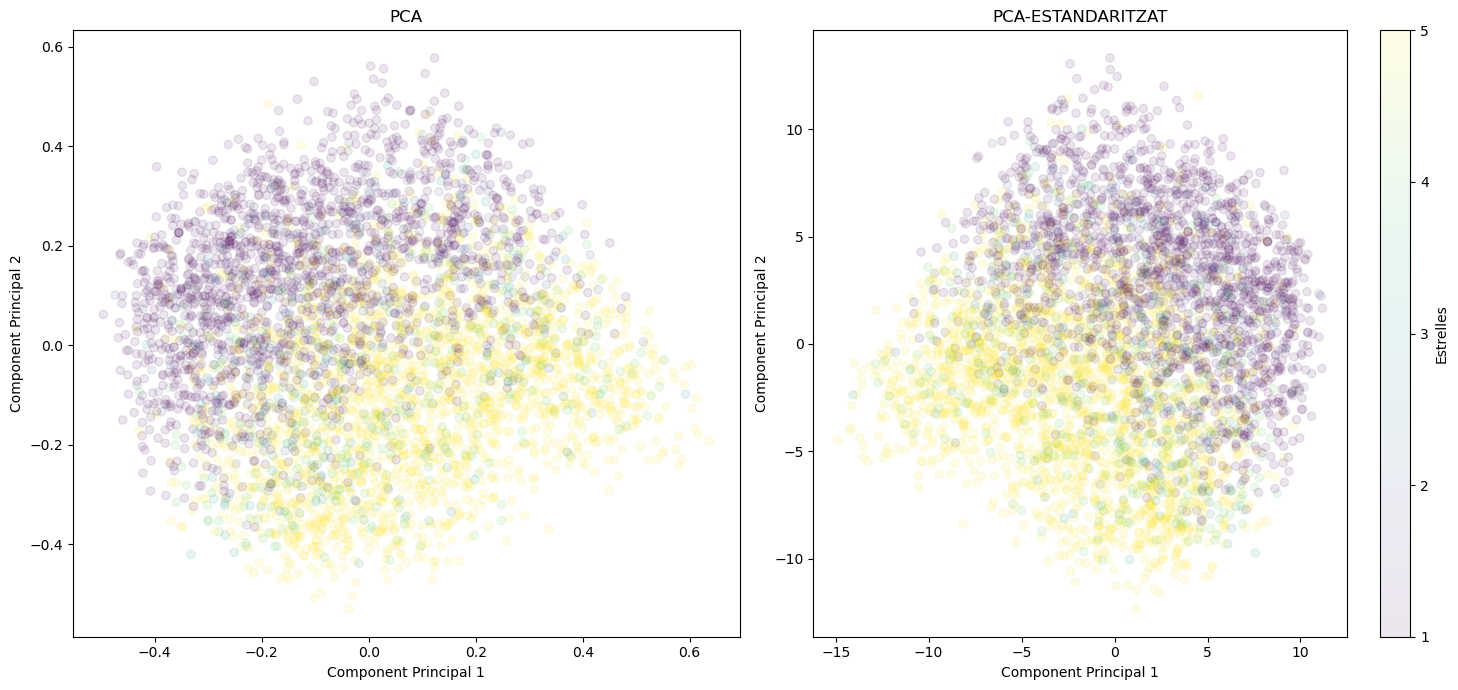

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandarditzar els embeddings
scaler = StandardScaler()
embeddings_standard = scaler.fit_transform(embeddings)

pca_no_standard = PCA(n_components=2)
embeddings_pca_no_standard = pca_no_standard.fit_transform(embeddings)

pca_standard = PCA(n_components=2)
embeddings_pca_standard = pca_standard.fit_transform(embeddings_standard)

colors = df['stars']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Gràfic PCA sense estandarditzar
scatter1 = ax1.scatter(embeddings_pca_no_standard[:, 0], embeddings_pca_no_standard[:, 1],
                       c=colors, cmap='viridis', alpha=0.1)
ax1.set_title("PCA")
ax1.set_xlabel("Component Principal 1")
ax1.set_ylabel("Component Principal 2")

# Gràfic PCA amb estandardització
scatter2 = ax2.scatter(embeddings_pca_standard[:, 0], embeddings_pca_standard[:, 1],
                       c=colors, cmap='viridis', alpha=0.1)
ax2.set_title("PCA-ESTANDARITZAT")
ax2.set_xlabel("Component Principal 1")
ax2.set_ylabel("Component Principal 2")

# Afegir llegenda amb les estrelles
cbar = fig.colorbar(scatter2, ax=ax2, ticks=[1, 2, 3, 4, 5])
cbar.set_label("Estrelles")

plt.tight_layout()
plt.show()


### t-SNE (t-distributed Stochastic Neighbor Embedding)
t-SNE és una tècnica per reduir la dimensionalitat preservant les relacions locals (és a dir, manté els punts similars a prop els uns dels altres). Tot i que és més lenta que PCA, t-SNE no projecta linealment.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> redueix a 2 dimensions cadascuna de les reviews i visualitza el resultat on el color de cada punt es correspongui amb les estrelles d'aquesta review. Afegeix una llegenda per poder interpretar els colors.
</div>

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,learning_rate=200, perplexity=60, n_iter=1000,early_exaggeration=11, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)  
embeddings_standard_tsne = tsne.fit_transform(embeddings_standard)  

C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")
C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in ver

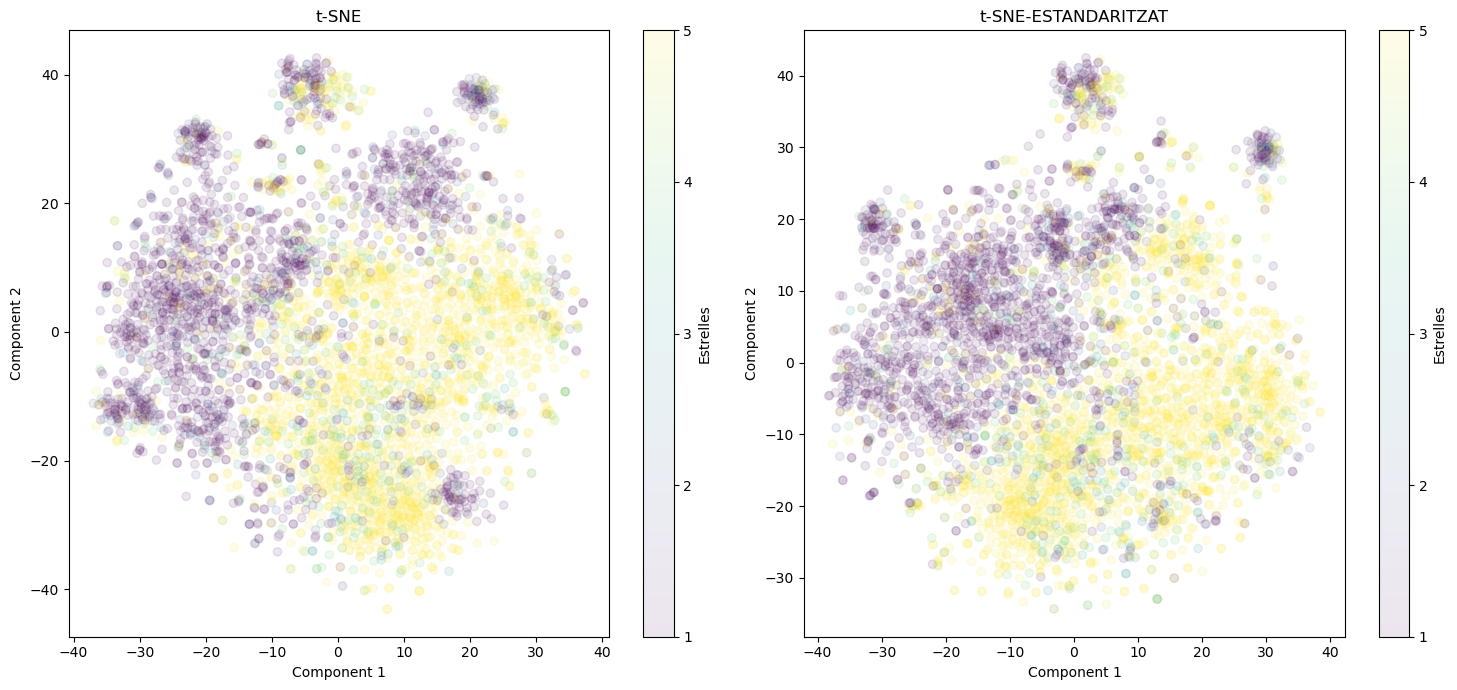

In [11]:
colors = df['stars']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Gràfic t-SNE
scatter1 = ax1.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1],
                      c=colors, cmap='viridis', alpha=0.1)
ax1.set_title("t-SNE")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

cbar = plt.colorbar(scatter1, ticks=[1, 2, 3, 4, 5])
cbar.set_label("Estrelles")


scatter2 = ax2.scatter(embeddings_standard_tsne[:, 0], embeddings_standard_tsne[:, 1],
                       c=colors, cmap='viridis', alpha=0.1)
ax2.set_title("t-SNE-ESTANDARITZAT")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

# Afegir llegenda amb les estrelles
cbar = fig.colorbar(scatter2, ax=ax2, ticks=[1, 2, 3, 4, 5])
cbar.set_label("Estrelles")

plt.tight_layout()
plt.show()

### UMAP (Uniform Manifold Approximation and Projection)
UMAP és una alternativa relativament nova que, igual que t-SNE, intenta mantenir les relacions locals, però sol ser més ràpida i permet una major flexibilitat per ajustar la precisió dels resultats.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> redueix a 2 dimensions cadascuna de les reviews i visualitza el resultat on el color de cada punt es correspongui amb les estrelles d'aquesta review. Afegeix una llegenda per poder interpretar els colors.
</div>

In [51]:
import umap

umap_model = umap.UMAP(n_components=2, random_state=42, n_neighbors=5)
embeddings_umap = umap_model.fit_transform(embeddings) 
embeddings_standard_umap = umap_model.fit_transform(embeddings_standard) 


tsne = TSNE(n_components=3,learning_rate=200, perplexity=60, n_iter=1000,early_exaggeration=11, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)  
embeddings_standard_tsne = tsne.fit_transform(embeddings_standard)  


pca_no_standard = PCA(n_components=3)
embeddings_pca_no_standard = pca_no_standard.fit_transform(embeddings)

pca_standard = PCA(n_components=3)
embeddings_pca_standard = pca_standard.fit_transform(embeddings_standard)

C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


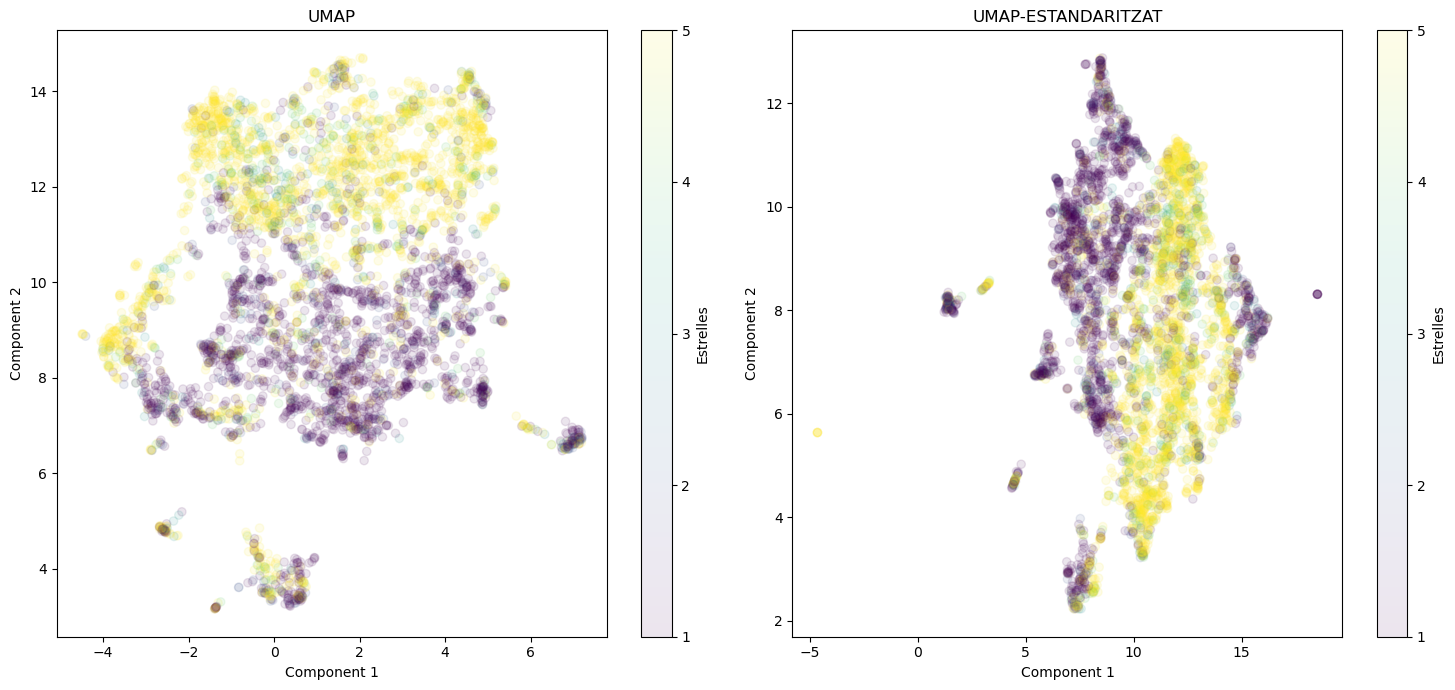

In [13]:
colors = df['stars']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Gràfic umap
scatter1 = ax1.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1],
                      c=colors, cmap='viridis', alpha=0.1)
ax1.set_title("UMAP")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")

cbar = plt.colorbar(scatter1, ticks=[1, 2, 3, 4, 5])
cbar.set_label("Estrelles")


scatter2 = ax2.scatter(embeddings_standard_umap[:, 0], embeddings_standard_umap[:, 1],
                       c=colors, cmap='viridis', alpha=0.1)
ax2.set_title("UMAP-ESTANDARITZAT")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")

# Afegir llegenda amb les estrelles
cbar = fig.colorbar(scatter2, ax=ax2, ticks=[1, 2, 3, 4, 5])
cbar.set_label("Estrelles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Què has observat després de la seva aplicació? Tot i no haver utilitzat la informació de les estrelles en realitzar els embeddings, sembla que existeix una relació entre la disposició dels embeddings i el nombre d'estrelles?
</div>

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Si haguessis de reduir la dimensionalitat per aplicar posteriorment un model d'aprenentatge supervisat que s'entrenarà una vegada i en producció farà prediccions diàries. Quins avantatges i desavantatges tindria cadascun dels mètodes? Per què?
</div>

### Validació en 3 dimensions

Després de visualitzar la reducció a dues dimensions, tria el mètode de reducció de dimensionalitat que consideris més adequat. A continuació, valida que les estructures identificades es mantenen en estendre la visualització a tres dimensions. Aquesta validació permet afegir més informació i verificar si els patrons observats persisteixen quan s'incorpora una dimensió addicional, la qual cosa proporciona una visió més completa de l'organització de les dades.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> crea un nou embedding projectant a 3 dimensions amb el mètode triat i visualitza amb matplotlib mantenint el color com a indicatiu del nombre d'estrelles de cada review.
</div>

In [14]:

umap_model_3d = umap.UMAP(n_components=3, random_state=42)
embeddings_umap_3d = umap_model_3d.fit_transform(embeddings)  
embeddings_standard_umap_3d = umap_model_3d.fit_transform(embeddings_standard)  

C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


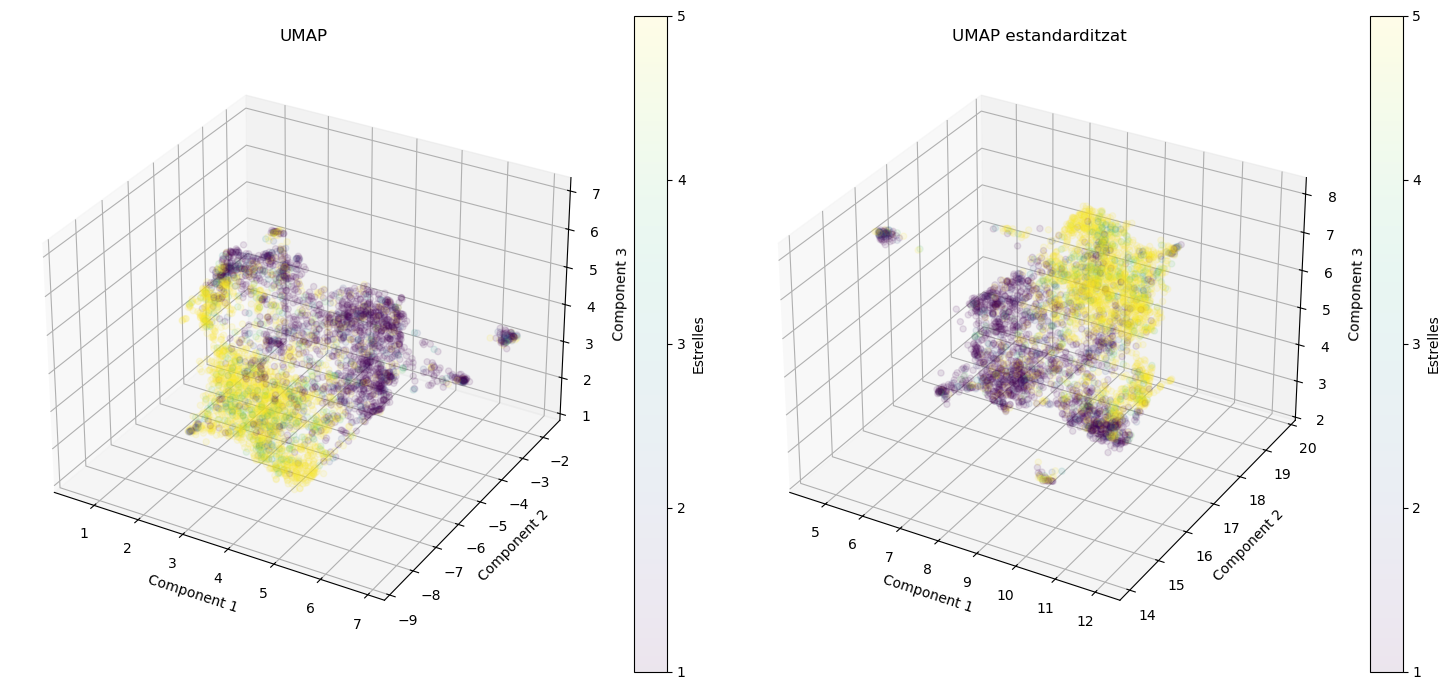

In [15]:
# Preparar els valors d'estrelles per als colors
colors = df['stars']

# Crear la figura amb dos subgràfics
fig = plt.figure(figsize=(15, 7))

# Gràfic UMAP sense estandarditzar
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(embeddings_umap_3d[:, 0], embeddings_umap_3d[:, 1], embeddings_umap_3d[:, 2],
                       c=colors, cmap='viridis', alpha=0.1)
ax1.set_title("UMAP")
ax1.set_xlabel("Component 1")
ax1.set_ylabel("Component 2")
ax1.set_zlabel("Component 3")

# Afegir llegenda per al primer gràfic
cbar1 = fig.colorbar(scatter1, ax=ax1, ticks=[1, 2, 3, 4, 5])
cbar1.set_label("Estrelles")

# Gràfic UMAP estandarditzat
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(embeddings_standard_umap_3d[:, 0], embeddings_standard_umap_3d[:, 1], embeddings_standard_umap_3d[:, 2],
                       c=colors, cmap='viridis', alpha=0.1)
ax2.set_title("UMAP estandarditzat")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_zlabel("Component 3")

# Afegir llegenda per al segon gràfic
cbar2 = fig.colorbar(scatter2, ax=ax2, ticks=[1, 2, 3, 4, 5])
cbar2.set_label("Estrelles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> És coherent aquesta visualització amb el que s'ha observat a la figura 2d?
</div>

### Dendrograma

A més de la visualització de les dades en 2 dimensions mitjançant mètodes de reducció de dimensionalitat, també podem intentar entendre com es distribueixen els punts en l'espai d'alta dimensionalitat utilitzant una tècnica diferent: el **dendrograma**.

Un dendrograma és una **representació gràfica que mostra l'estructura jeràrquica d'un conjunt de dades**. Aquest tipus de gràfic és especialment útil per entendre les relacions entre punts de dades quan volem agrupar-los de manera jeràrquica. El dendrograma es genera com a part de l'algorisme de clustering jeràrquic, el qual intenta agrupar les dades de manera recursiva, creant una estructura en forma d'arbre on cada fulla representa un punt del dataset i cada bifurcació representa la unió de dos grups.

Com interpretar un dendrograma:

A la part inferior del dendrograma, cada fulla representa una dada individual (en aquest cas, una review).
- A mesura que ens movem cap amunt, els punts que estan més propers entre si es van agrupant, i aquests grups s'uneixen en nivells superiors fins que, eventualment, tots els punts es junten en un únic grup a la part superior.
- Les distàncies verticals indiquen la similitud o dissimilitud entre els grups que s'estan unint. Com més gran és l'altura a la qual s'uneixen dos grups, més gran és la dissimilitud entre ells. Per tant, un dendrograma ens dóna una idea visual de quins punts estan més a prop els uns dels altres i com els clusters més petits es fusionen per formar clusters més grans.
- Utilitzant un dendrograma, podem decidir quants clusters té sentit crear, observant on seria adequat tallar l'arbre. Per exemple, si trobem un punt on els grups comencen a unir-se amb una gran distància, això podria indicar que és un bon lloc per tallar i definir el nombre de clusters.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> visualitza el dendrograma tenint en compte aquests paràmetres:
<ul>
<li><strong>truncate_mode='level'</strong>: limita la profunditat del dendrograma, mostrant només un nombre determinat de nivells d'unió, cosa que és útil per evitar un gràfic excessivament complex.

<li><strong>p=200</strong>: quants clusters o nivells es mostraran. En aquest cas, es visualitzaran fins a 500 grups, permetent un bon equilibri entre detall i simplicitat.

<li><strong>no_labels=True</strong>: oculta les etiquetes de cada punt per evitar que el gràfic es vegi sobrecarregat i es generi més ràpidament.

<li><strong>method='single'</strong>: és una manera intuïtiva d'agrupar les mostres, ja que defineix la distància entre dos grups com la distància entre els punts més propers de cada grup.
</ul>
</div>

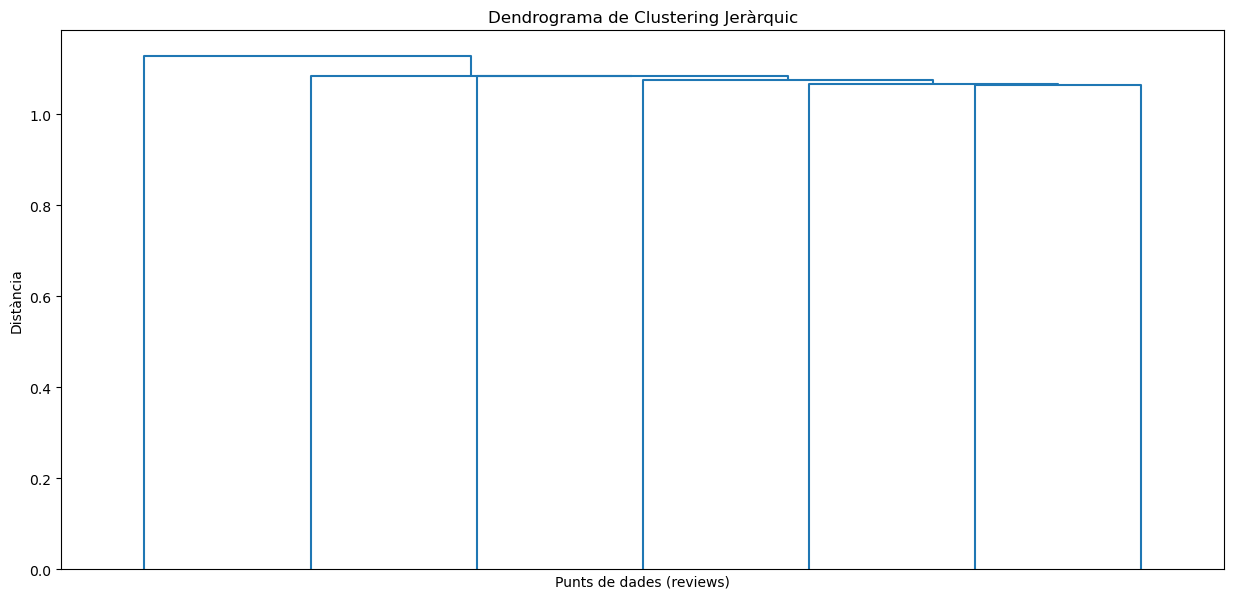

In [22]:
data = embeddings
# Generar el linkage per al clustering jeràrquic
linkage_matrix = linkage(data, method='single')

# Crear el dendrograma amb els paràmetres especificats
plt.figure(figsize=(15, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=5, no_labels=True)
plt.title("Dendrograma de Clustering Jeràrquic")
plt.xlabel("Punts de dades (reviews)")
plt.ylabel("Distància")
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Què podem observar en el dendrograma? Hi ha alguna cosa semblant a l'observat en les reduccions de dimensionalitat?
</div>

## Clustering (3 punts)

Després d'haver visualitzat el conjunt de dades i examinat el dendrograma, hem obtingut una visió més profunda sobre l'estructura i les relacions internes del dataset. Aquesta informació ens ajudarà a prendre una decisió informada sobre quina és la millor estratègia de clustering a seguir. Tanmateix, abans de definir la nostra estratègia final, és important explorar com funcionen diferents algorismes de clustering, per comprendre millor els seus avantatges i limitacions.

En aquest context, realitzarem alguns experiments utilitzant diferents algorismes de clustering. Provarem enfocaments com **K-means**, **clustering jeràrquic**, **DBSCAN**, i **Mean-Shift**.

Per a això, comptem amb els següents datasets:

In [16]:
n_samples = 1000
blobs_data, blobs_labels = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=seed)
moons_data, moons_labels = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
circles_data, circles_labels = datasets.make_circles(n_samples=n_samples, factor=0.4, noise=0.05, random_state=seed)

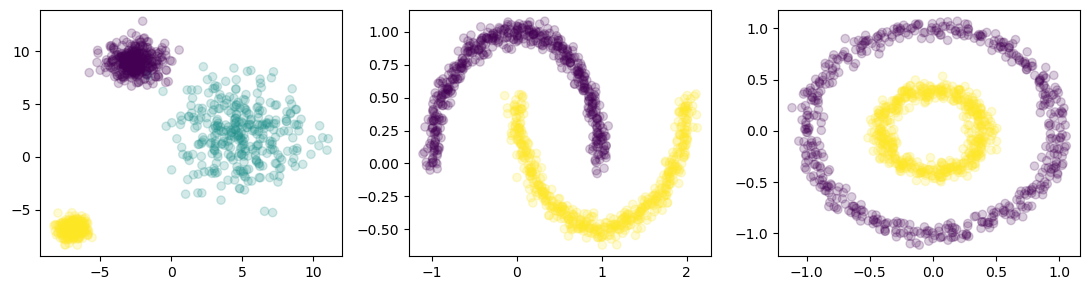

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(11, 3))
ax[0].scatter(blobs_data[:,0], blobs_data[:,1], c=blobs_labels, alpha=.2)
ax[1].scatter(moons_data[:,0], moons_data[:,1], c=moons_labels, alpha=.2)
ax[2].scatter(circles_data[:,0], circles_data[:,1], c=circles_labels, alpha=.2)
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica K-means als tres datasets anteriors i visualitza el seu resultat.
</div>

C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\tvive\anaconda3\envs\environment_uoc20241pec2\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


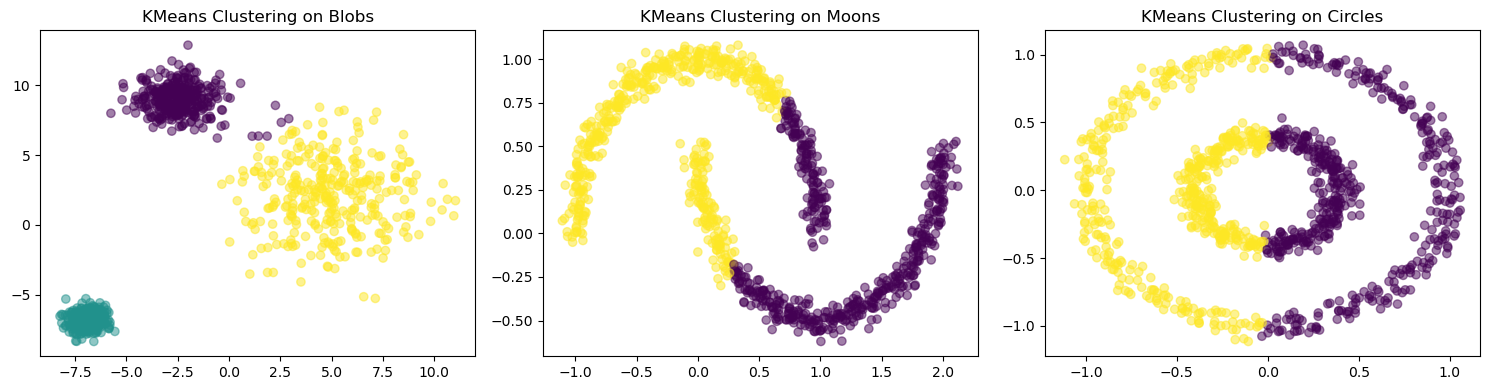

In [23]:
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np

# Apply KMeans clustering to each dataset
kmeans_blobs = KMeans(n_clusters=3, random_state=seed).fit(blobs_data)
kmeans_moons = KMeans(n_clusters=2, random_state=seed).fit(moons_data)
kmeans_circles = KMeans(n_clusters=2, random_state=seed).fit(circles_data)

# Plot original datasets with KMeans clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot Blobs data
ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=kmeans_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("KMeans Clustering on Blobs")

# Plot Moons data
ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=kmeans_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("KMeans Clustering on Moons")

# Plot Circles data
ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=kmeans_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("KMeans Clustering on Circles")

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica clustering jeràrquic als tres datasets anteriors i visualitza el seu resultat.
</div>

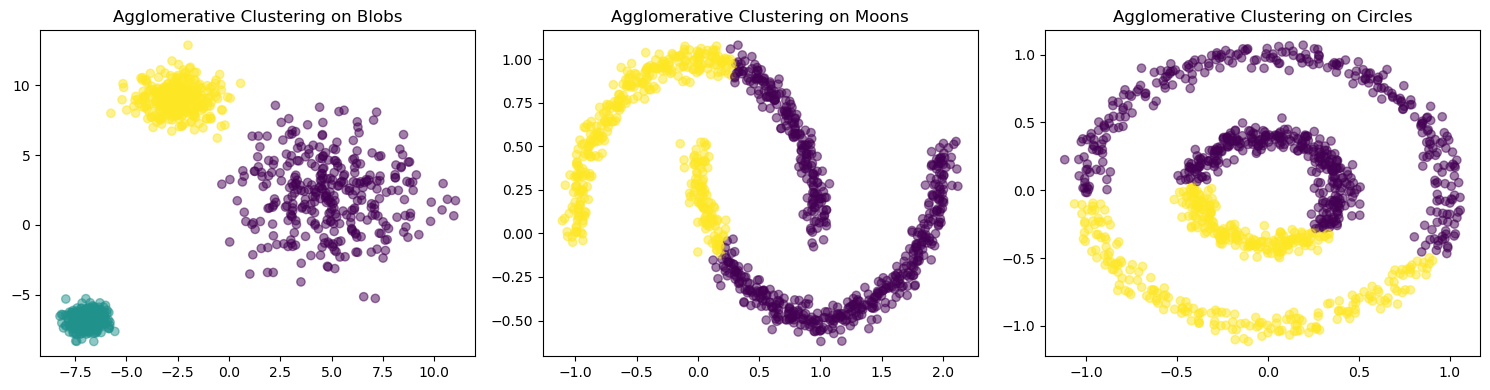

In [25]:
agg_clustering_blobs = AgglomerativeClustering(n_clusters=3).fit(blobs_data)
agg_clustering_moons = AgglomerativeClustering(n_clusters=2).fit(moons_data)
agg_clustering_circles = AgglomerativeClustering(n_clusters=2).fit(circles_data)


fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot Blobs data
ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=agg_clustering_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("Agglomerative Clustering on Blobs")

# Plot Moons data
ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=agg_clustering_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("Agglomerative Clustering on Moons")

# Plot Circles data
ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=agg_clustering_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("Agglomerative Clustering on Circles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica DBSCAN als tres datasets anteriors i visualitza el seu resultat.
</div>

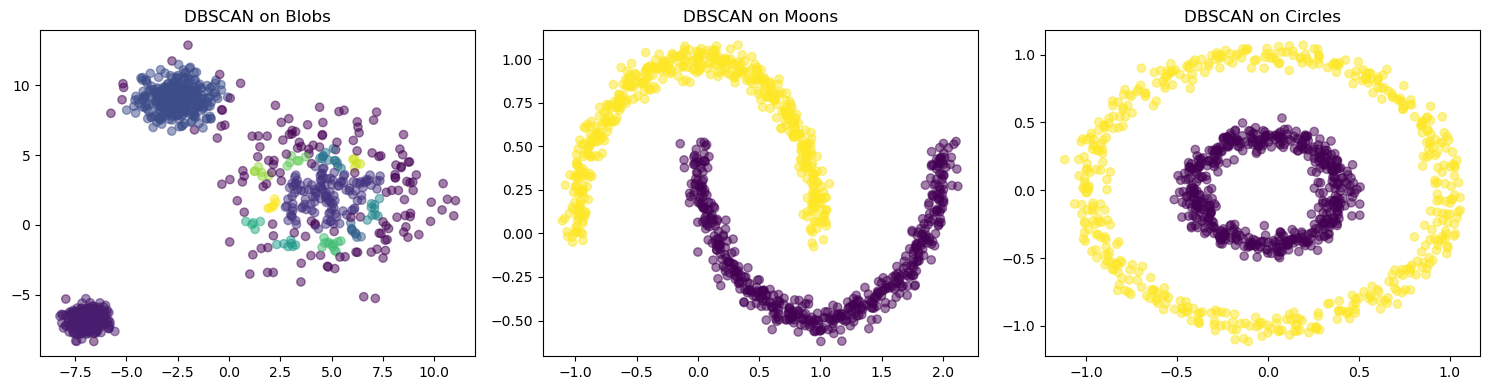

In [26]:
# Apply DBSCAN clustering to each dataset
dbscan_blobs = DBSCAN(eps=0.5, min_samples=5).fit(blobs_data)
dbscan_moons = DBSCAN(eps=0.2, min_samples=5).fit(moons_data)
dbscan_circles = DBSCAN(eps=0.2, min_samples=5).fit(circles_data)

# Plot original datasets with DBSCAN results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot Blobs data
ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=dbscan_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("DBSCAN on Blobs")

# Plot Moons data
ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=dbscan_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("DBSCAN on Moons")

# Plot Circles data
ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=dbscan_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("DBSCAN on Circles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica Mean-shift als tres datasets anteriors i visualitza el seu resultat.
</div>

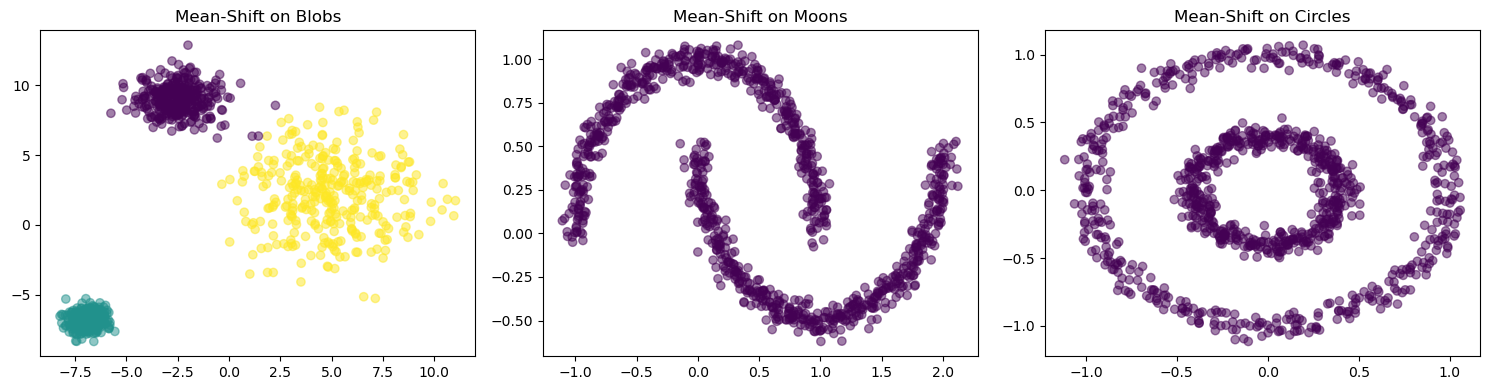

In [27]:
# Apply MeanShift clustering to each dataset
mean_shift_blobs = MeanShift().fit(blobs_data)
mean_shift_moons = MeanShift().fit(moons_data)
mean_shift_circles = MeanShift().fit(circles_data)

# Plot original datasets with Mean-Shift results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Plot Blobs data
ax[0].scatter(blobs_data[:, 0], blobs_data[:, 1], c=mean_shift_blobs.labels_, cmap='viridis', alpha=0.5)
ax[0].set_title("Mean-Shift on Blobs")

# Plot Moons data
ax[1].scatter(moons_data[:, 0], moons_data[:, 1], c=mean_shift_moons.labels_, cmap='viridis', alpha=0.5)
ax[1].set_title("Mean-Shift on Moons")

# Plot Circles data
ax[2].scatter(circles_data[:, 0], circles_data[:, 1], c=mean_shift_circles.labels_, cmap='viridis', alpha=0.5)
ax[2].set_title("Mean-Shift on Circles")

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> En quins casos no s'ha pogut ajustar el resultat del model als clusters originals? Per què?
</div>

Ara que has experimentat amb diversos algorismes de clustering i has comprès els seus avantatges i desavantatges, és moment de prendre una decisió important:

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Quin algorisme de clustering seleccionaràs per agrupar el conjunt de dades de reviews? Per què?
</div>

**Aplica'l al conjunt de dades de reviews**. Si trobes problemes de rendiment a causa de la mida del conjunt de dades original, pots reduir el problema utilitzant un conjunt de punts en 3D en lloc de la dada original perquè el càlcul sigui més ràpid i eficient.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> aplica l'algorisme de clustering seleccionat al conjunt de dades de reviews i visualitza el seu resultat. Modifica els paràmetres de l'algorisme perquè s'adapti a la dada.
</div>

## Anàlisi dels clusters (3 punts)

Ara que has realitzat el clustering, és moment d'analitzar els resultats obtinguts per poder proporcionar insights al negoci.

<div class="alert alert-block alert-info">
<strong>Implementació:</strong> revisa la composició dels clusters. <strong>Per a cada cluster</strong> identificat, has de mostrar de manera clara i organitzada la informació següent:
<ul>
<li><strong>Nombre de reviews</strong> assignades a aquest cluster.
<li><strong>Mitjana d'estrelles</strong> de les reviews dins d'aquest cluster.
<li><strong>Reviews representatives:</strong> selecciona 5 reviews per a cada cluster que permetin tenir una idea general del seu contingut. Si el mètode de clustering utilitzat calcula els centroides (és a dir, el "centre" del cluster), selecciona les 5 reviews més properes al centre per a una representació més precisa.
Si el mètode no calcula centroides, simplement selecciona qualsevol 5 reviews del cluster.
</ul>
</div>

L'últim pas és la interpretació dels clusters mitjançant l'anàlisi de les mostres pertanyents a cada cluster.

<div class="alert alert-block alert-info">
<strong>Anàlisi:</strong> Pots identificar diferents temes o patrons en els missatges de cada cluster? Comenta la temàtica de cada cluster.
</div>